In [ ]:
#TODO: aggiungere commenti
    # ricreare tabelle con indicazione di precision
# TODO: testare tutto, sistemare in ambiente distribuito

# ML algorithm for pattern classification
This notebook contains the definitions and training pipeline of the machine learning algorithms applied in the paper.
For each algorithm, a model will be created with the same hyperparameters as the ones declared in the paper (defaults hyperparameters of <code>sklearn</code>).

Said model will be trained and tested on the split already provided from the beginning of the SeqScout procedure. In this way, we can have a score that is as much as comparable as possible with the values reported by the paper.


Then, an hyperparameter search will be conducted on the models via cross validation on the training split. The best performing model will be again trained on the full train set and tested on test set, in order to compare it to the default model.
Each model will be compared on accuracy, precision and recall. Moreover, the confusion matrix for each best performing model will be produced.

## Major differences
Aside from the machine learning library employed, the presented algorithms differ from the original paper in a couple of aspects:
- They use the OneVsRest classifier for each model, while we use directly the multiclass classifier (except for the LinearSVC). This allows to save time on the model training and consequently on the hyperparameter search.
- The results will be computed on a single test split equal to a fifth of the original dataset. This split follows the same split employed for k-fold evaluation in the original paper. This choice was made considering the high overhead required when computing the patterns.
- As SVM model, pyspark has only the LinearSVC implemented, thus it will be used in place of SVC. In this case, the default parameter considered for the baseline model will be the ones provided by pyspark.

## Imports and library installation
As the default package of PySpark does not include the algorithm for the XGBoost, a cell to install the appropriate libraries is added

In [3]:
!pip install scikit-learn
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 1.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 7.0 MB/s eta 0:00:0000:0100:01


In [1]:
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, LinearSVC, OneVsRest, NaiveBayes
from pyspark.ml.classification import DecisionTreeClassificationModel, RandomForestClassificationModel, OneVsRestModel, NaiveBayesModel
from pyspark.mllib.tree import RandomForestModel, DecisionTreeModel
from pyspark.ml.tuning import CrossValidatorModel
from xgboost.spark import SparkXGBClassifier, SparkXGBClassifierModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from utils import load_df
import numpy as np
import pyspark.sql.functions as F
from pyspark.sql.types import FloatType, IntegerType
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.ml.stat import Summarizer

## Dataset loading, function definitions and brief preliminary analysis
As first step, we load the already encoded dataframes for training and testing the algorithms. We also set the path where the models will be saved as well as the random seed for reproducibility.

In [17]:
spark = SparkSession.builder.appName("RocketLeagueL").getOrCreate()

path = "./dataset/"
#path = 'hdfs://hdmaster:9000/user/ubuntu/dataset/'
modelpath = path + 'models/'
train = load_df(path, "encoded_df", spark)
test = load_df(path, "encoded_test", spark)
seed = 42


Cells for the loading of checkpoints of the trained models are then added

In [17]:
# loads base models
print("Loading decision tree...")
dtcf = DecisionTreeClassificationModel.load(modelpath + 'decision_tree/base')
print("Loading random forest...")
rfcf = RandomForestClassificationModel.load(modelpath + 'random_forest/base')
print("Loading XGBoost...")
xgbf = SparkXGBClassifierModel.load(modelpath + 'xgb/base')
print("Loading SVM...")
svmf = OneVsRestModel.load(modelpath + 'svm/base')
print("Loading Naive Bayes...")
nbf = NaiveBayesModel.load(modelpath + 'nb/base')

Loading decision tree...
Loading random forest...


Loading XGBoost...
Loading SVM...
Loading Naive Bayes...


In [19]:
# loads tuned models (takes some time)
print("Loading tuned decision tree...")
dtc_cv_model = CrossValidatorModel.load(modelpath + 'decision_tree/hyperParameterTuned')
print("Loading tuned random forest...")
rfc_cv_model = CrossValidatorModel.load(modelpath + 'random_forest/hyperParameterTuned')
print("Loading tuned XGBoost...")
xgb_cv_model = CrossValidatorModel.load(modelpath + 'xgb/hyperParameterTuned2')
print("Loading tuned SVM...")
svm_cv_model = CrossValidatorModel.load(modelpath + 'svm/hyperParameterTuned')
print("Loading tuned Naive Bayes...")
nb_cv_model = CrossValidatorModel.load(modelpath + 'nb/hyperParameterTuned')

Loading tuned decision tree...
Loading tuned random forest...
Loading tuned XGBoost...
Loading tuned SVM...
Loading tuned Naive Bayes...


Then, a couple of function are defined in order to automatically compute the evaluation metrics and to print them together with the confusion matrix. Moreover, to improve the readability of the produced graph, the list of labels for the classes is also added.

In [4]:
ordered_labels = ['Noise', 
                      'Ceiling Shot', 
                      'Power Shot', 
                      'Waving Dash',
                      'Air Dribbling',
                      'Front Flick',
                      'Musty Flick']

def compute_metrics(prediction_df):
    """
    Function computing some metrics for the evaluation of the machine learning models. It uses MulticlassMetrics from
    the pyspark library.
    params:
        prediction_df: pyspark dataframe containing at least a prediction column called "prediction"
                       amd a class colimn called "class"
    returns:
        a MulticlassMetrics object containing the metrics about the prediction_df
    """
    rdd_pred = prediction_df.select("prediction", "class").withColumn("class",F.col('class').cast(FloatType())).orderBy('class').rdd.map(tuple)
    metrics = MulticlassMetrics(rdd_pred)
    return metrics

def print_metrics(prediction_df, ordered_labels=ordered_labels):
    """
    Function printing some metrics for evaluation, as well as the confusion matrix given a pyspark dataframe
    with ground truth labels and predictions. The confusion matrix is printed with values normalized on the true
    positives and false negatives (recall)
    params:
        prediction_df: pyspark dataframe containing at least a prediction column
                       called "prediction" and a class column called "class"
        ordered_labels: list of labels whose position order corresponds to the position order of the corresponding class values
    """
    metrics = compute_metrics(prediction_df)
    print("Accuracy: ")
    print(f'%.3f'%metrics.accuracy)
    print("Weighted precision: ")
    print(f'%.3f'%metrics.weightedPrecision)
    print("Weighted recall: ")
    print(f'%.3f'%metrics.weightedRecall)
    cm = metrics.confusionMatrix().toArray()
    cm = cm / (cm.sum(axis=1))
    
    sns.heatmap(cm, annot=True, xticklabels=ordered_labels, yticklabels=ordered_labels)
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    return metrics
    

In the following barplots we verify again that the class distribution is equal between the training and the test split, as a stratified one was performed during the pre-processing procedure. The only classes that are slightly skewed in the test set w.r.t. the trianing one are the "Air Dribbling" and "Front Flick" classes.

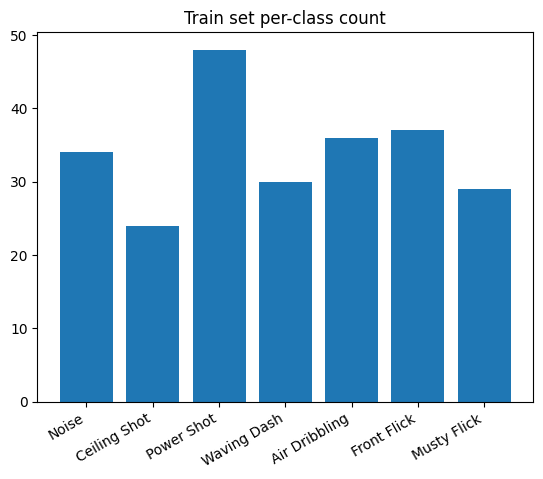

In [87]:
# getting per class counts
hist_data_train = train.groupBy('class').count().sort('class').collect()
# setting label alignment and rotation
ax = plt.gca()
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
# plotting the values
plt.title("Train set per-class count")
plt.bar(np.arange(len(ordered_labels)),[i['count'] for i in hist_data_train], tick_label=ordered_labels)
plt.show()

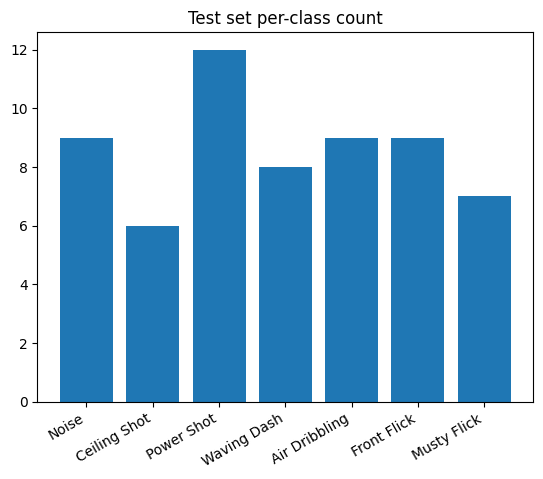

In [86]:
hist_data_test = test.groupBy('class').count().sort('class').collect()
# setting label alignment and rotation
ax = plt.gca()
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
# plotting the values
plt.title("Test set per-class count")
plt.bar(np.arange(len(ordered_labels)),[i['count'] for i in hist_data_test], tick_label=ordered_labels)
plt.show()

# da qui
Then, since at this point the dataset is mainly constituted of binary features indicating whether a specific pattern has been found in a sequence, we can see how these pattern effectively encode the charateristics of a class. In order to do so, we group the DataFrame by class, sum over the values of the binary feature  

In [78]:
def show_heatmap(dataframe, c="class", feats="features", ordered_labels=ordered_labels):
    """
    Function printing the heatmap of a given binary dataframe. In particular, the function groups the rows by the column
    c, sums the values in feats and then turns them into percentage.
    params:
        dataframe: input dataframe containing the information to be aggregated
        c: column name to be used to group the records
        feats: name of the column to be aggregated
        ordered_labels: list of ordered names to be given to the rows of the heatmap
    """
    summarized_df = dataframe.groupBy(c).agg(Summarizer.sum(F.col(feats)).alias("per_c_sum")).orderBy(c)\
                    .select("per_c_sum")
    norm = summarized_df.agg(Summarizer.sum(summarized_df.per_c_sum).alias("norm")).collect()[0].asDict()["norm"] 
    if norm.numNonzeros() != len(norm):
        norm = norm.toArray()
        norm[norm == 0.] = 1
    summarized_df = summarized_df.collect()
    summarized_df = [summarized_df[i].asDict()["per_c_sum"]/norm for i in range(len(summarized_df))]
    fig, ax = plt.subplots(figsize=(25,3)) 
    sns.heatmap(summarized_df, yticklabels=ordered_labels, ax=ax)
    plt.xlabel("features")
    plt.show()

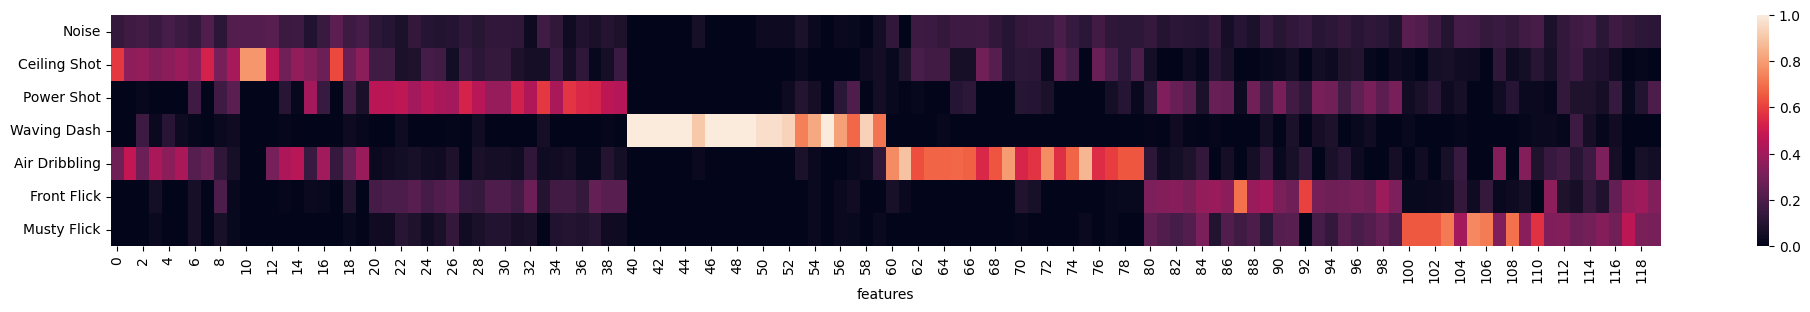

In [79]:
show_heatmap(train)

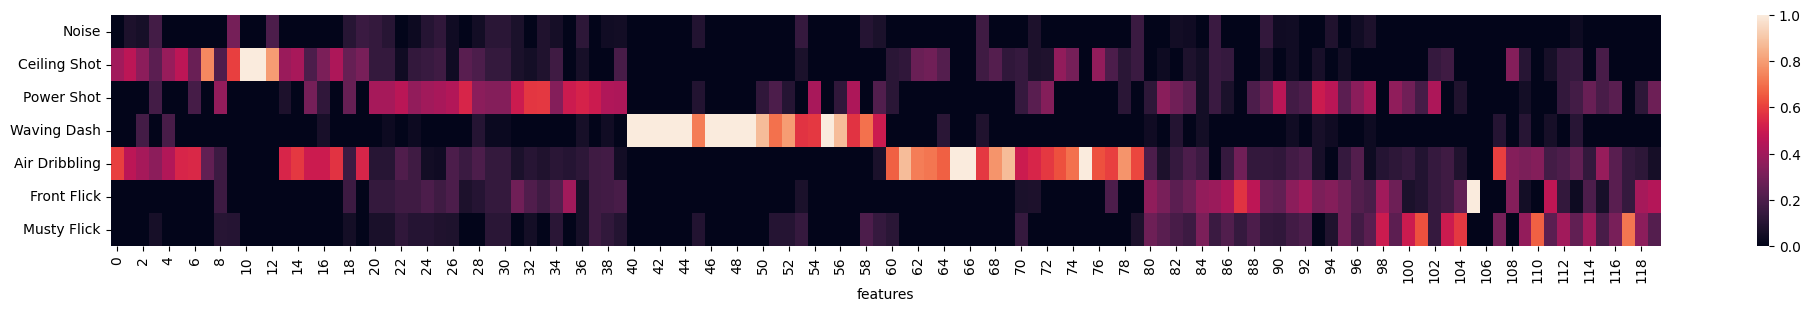

In [80]:
show_heatmap(test)

## Decision Tree

In [8]:
dtc = DecisionTreeClassifier(maxDepth=30, seed=seed, featuresCol='features', labelCol='class')
# apparently 30 is the currently supported maximum depth for pyspark

dtcf = dtc.fit(train)
dtcf.save(path+"models/decision_tree/base")
dtc_predictions = dtcf.transform(test)

+----------+-----+
|prediction|class|
+----------+-----+
|       4.0|    4|
|       5.0|    5|
|       5.0|    5|
|       0.0|    5|
|       5.0|    5|
+----------+-----+
only showing top 5 rows



/usr/local/spark-3.3.1-bin-hadoop3/python/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Accuracy: 
0.733
Weighted precision: 
0.823
Weighted recall: 
0.733


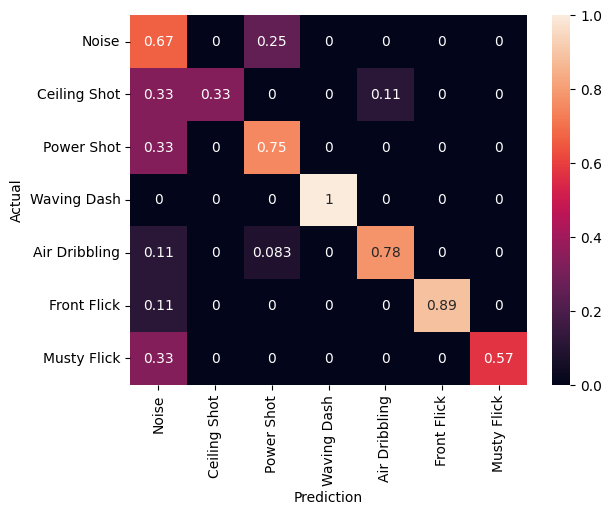

In [11]:
dtc_predictions.select("prediction", "class").show(5)
print_metrics(dtc_predictions)

In [65]:
dtc_cv = DecisionTreeClassifier(featuresCol='features', labelCol='class',seed=seed)

dtc_param_grid = ParamGridBuilder()\
                .addGrid(dtc_cv.impurity, ['gini', 'entropy'])\
                .addGrid(dtc_cv.maxDepth, [i+1 for i in range(3,15)])\
                .addGrid(dtc_cv.minInstancesPerNode, [i+1 for i in range(5)])\
                .addGrid(dtc_cv.minInfoGain, [0.1*i for i in range(11)]).build()

evaluator = MulticlassClassificationEvaluator(labelCol='class', predictionCol='prediction', metricName='accuracy')

dtc_cross_val = CrossValidator(estimator=dtc_cv,
                              estimatorParamMaps=dtc_param_grid,
                              evaluator=evaluator,
                              numFolds=4,
                              parallelism=2,
                              seed=seed)


In [7]:
dtc_cv_model = dtc_cross_val.fit(train)

In [45]:
print("Best parameters:")
print({k.name : v for (k,v) in dtc_cv_model.getEstimatorParamMaps()[np.argmax(dtc_cv_model.avgMetrics)].items()})
dtc_cv_model.save(path+"models/decision_tree/hyperParameterTuned")

Best parameters:
{'minInfoGain': 0.2, 'minInstancesPerNode': 2, 'impurity': 'entropy', 'maxDepth': 7}


+----------+-----+
|prediction|class|
+----------+-----+
|       4.0|    4|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
+----------+-----+
only showing top 5 rows

Accuracy: 
0.800
Weighted precision: 
0.846
Weighted recall: 
0.800


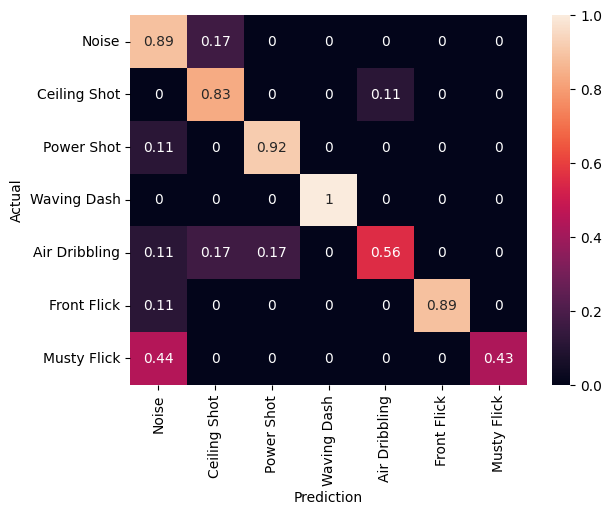

In [41]:
dtc_best_pred = dtc_cv_model.transform(test)
dtc_best_pred.select("prediction", 'class').show(5)
print_metrics(dtc_best_pred)

## Random Forest

In [ ]:
rfc = RandomForestClassifier(featuresCol='features',
                             labelCol='class',
                             featureSubsetStrategy='sqrt',
                             maxDepth=30,
                             numTrees=100,
                             seed=seed)

rfcf = rfc.fit(train)
rfcf.save(path+"models/random_forest/base")
rfc_predictions = rfcf.transform(test)

23/09/24 23:44:22 WARN DAGScheduler: Broadcasting large task binary with size 1381.0 KiB
+-----+----------+
|class|prediction|
+-----+----------+
|    4|       4.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
+-----+----------+
only showing top 5 rows

23/09/24 23:44:22 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
23/09/24 23:44:22 WARN DAGScheduler: Broadcasting large task binary with size 1384.6 KiB
23/09/24 23:44:22 WARN DAGScheduler: Broadcasting large task binary with size 1392.9 KiB
Accuracy: 
23/09/24 23:44:22 WARN DAGScheduler: Broadcasting large task binary with size 1403.3 KiB
0.850
Weighted precision: 
0.874
Weighted recall: 
0.850


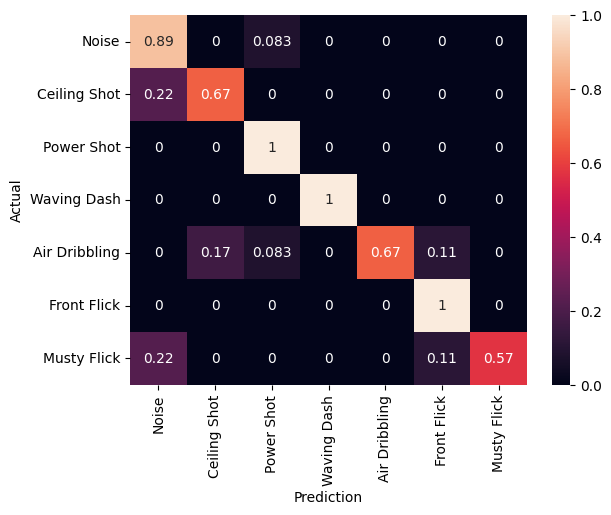

In [42]:
rfc_predictions.select('class', 'prediction').show(5)
print_metrics(rfc_predictions)

In [12]:
rfc_cv = RandomForestClassifier(featuresCol='features', labelCol='class',seed=seed)
# in hyperparameters optimization we are considering only the automatic feature selection methods
rfc_param_grid = ParamGridBuilder()\
                .addGrid(rfc_cv.impurity, ['gini', 'entropy'])\
                .addGrid(rfc_cv.maxDepth, [i+1 for i in range(3,10)])\
                .addGrid(rfc_cv.minInstancesPerNode, [i+1 for i in range(3)])\
                .addGrid(rfc_cv.minInfoGain, [0.2*i for i in range(1,6)])\
                .addGrid(rfc_cv.featureSubsetStrategy, ['sqrt', 'all', 'log2', 'onethird'])\
                .addGrid(rfc_cv.numTrees, [25*i for i in range(1,9)])\
                .addGrid(rfc_cv.subsamplingRate, [0.2*i for i in range(1, 6)]).build()

evaluator = MulticlassClassificationEvaluator(labelCol='class', predictionCol='prediction', metricName='accuracy')

rfc_cross_val = CrossValidator(estimator=rfc_cv,
                              estimatorParamMaps=rfc_param_grid,
                              evaluator=evaluator,
                              numFolds=4,
                              parallelism=2,
                              seed=seed)


In [ ]:
rfc_cv_model = rfc_cross_val.fit(train)

In [46]:
print("Best parameters:")
print({k.name : v for (k,v) in rfc_cv_model.getEstimatorParamMaps()[np.argmax(rfc_cv_model.avgMetrics)].items()})
rfc_cv_model.save(path+"models/random_forest/hyperParameterTuned")

Best parameters:
{'featureSubsetStrategy': 'onethird', 'numTrees': 25, 'maxDepth': 7, 'impurity': 'entropy', 'minInfoGain': 0.2, 'minInstancesPerNode': 1, 'subsamplingRate': 0.8}


+----------+-----+
|prediction|class|
+----------+-----+
|       4.0|    4|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
+----------+-----+
only showing top 5 rows

Accuracy: 
0.883
Weighted precision: 
0.897
Weighted recall: 
0.883


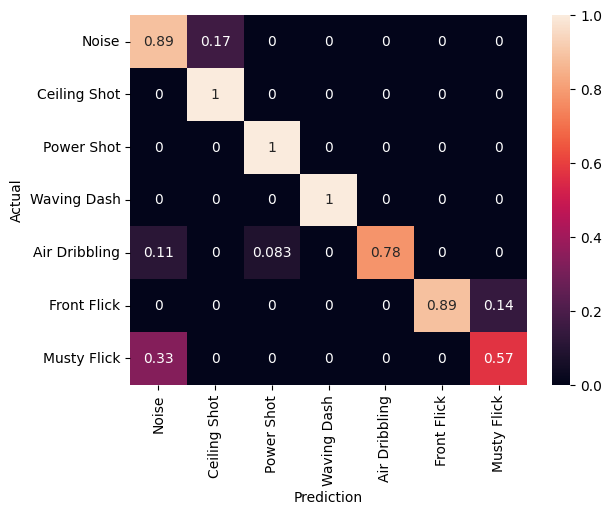

In [47]:
rfc_best_pred = rfc_cv_model.transform(test)
rfc_best_pred.select("prediction", 'class').show(5)
print_metrics(rfc_best_pred)

## XGBoost

In [17]:
xgb = SparkXGBClassifier(features_col='features',
                         label_col='class',
                         random_state=seed)
xgbf = xgb.fit(train)
xgbf.save(path+'models/xgb/base')
xgb_predictions = xgbf.transform(test)

2023-09-17 20:56:02,491 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'multi:softprob', 'device': 'cpu', 'max_depth': 7, 'random_state': 42, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[20:56:03] task 0 got new rank 0                                    (0 + 1) / 1]
2023-09-17 20:56:04,981 INFO XGBoost-PySpark: _fit Finished xgboost training!   


2023-09-24 23:45:42,230 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


+-----+----------+
|class|prediction|
+-----+----------+
|    4|       4.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
+-----+----------+
only showing top 5 rows



2023-09-24 23:45:43,061 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2023-09-24 23:45:43,164 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


Accuracy: 
0.833
Weighted precision: 
0.899
Weighted recall: 
0.833


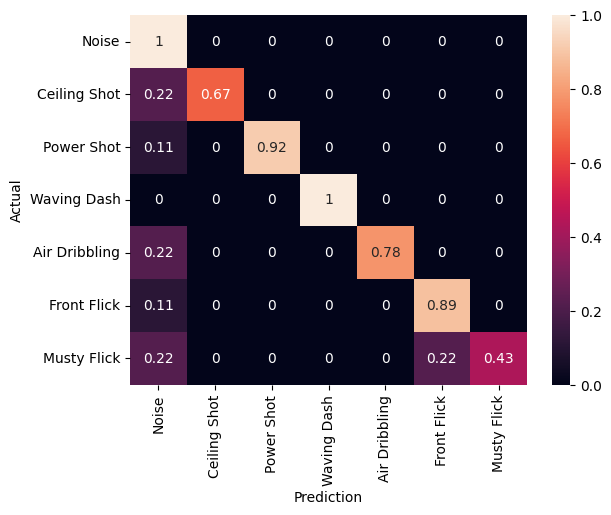

In [48]:
xgb_predictions.select('class', 'prediction').show(5)
print_metrics(xgb_predictions)

In [24]:
xgb_cv = SparkXGBClassifier(features_col='features',
                         label_col='class',
                         verbose=0,
                         random_state=seed)

xgb_param_grid = ParamGridBuilder()\
                .baseOn({xgb_cv.verbose:0})\
                .addGrid(xgb_cv.learning_rate, [0.01, 0.1, 0.3])\
                .addGrid(xgb_cv.max_depth, [i for i in range(5,9)])\
                .addGrid(xgb_cv.reg_lambda, [0, 0.1, 0.5, 1])\
                .addGrid(xgb_cv.reg_alpha, [0, 0.1, 0.5, 1])\
                .addGrid(xgb_cv.colsample_bytree, [0.5, 0.75, 1])\
                .addGrid(xgb_cv.n_estimators, [50, 100, 200]).build()
"""
fixed: min_child_weight 1, gamma 0, subsample 1
"""
evaluator = MulticlassClassificationEvaluator(labelCol='class', predictionCol='prediction', metricName='accuracy')

xgb_cross_val = CrossValidator(estimator=xgb_cv,
                              estimatorParamMaps=xgb_param_grid,
                              evaluator=evaluator,
                              numFolds=4,
                              parallelism=2,
                              seed=seed)


In [ ]:
xgb_cv_model = xgb_cross_val.fit(train)

In [58]:
print("Best parameters:")
print({k.name : v for (k,v) in xgb_cv_model.getEstimatorParamMaps()[np.argmax(xgb_cv_model.avgMetrics)].items()})
xgb_cv_model.save(path+"models/xgb/hyperParameterTuned")

Best parameters:
{'verbose': 0, 'learning_rate': 0.1, 'max_depth': 7, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'colsample_bytree': 1, 'n_estimators': 100}


In [97]:
j=0
print((len(xgb_cv_model.avgMetrics)))
for k in [0, 0.1, 0.5, 1]:
    local_max = 0
    for i in range(len(xgb_cv_model.avgMetrics)):
        if {k.name : v for (k,v) in xgb_cv_model.getEstimatorParamMaps()[i].items()}['reg_alpha']==k:
            if xgb_cv_model.avgMetrics[i] > xgb_cv_model.avgMetrics[local_max]:
                local_max = i
            #print("-------------")
            #print({k.name : v for (k,v) in xgb_cv_model.getEstimatorParamMaps()[i].items()})
            #print(xgb_cv_model.avgMetrics[i])
    print(f'------ {k}')
    print({k.name : v for (k,v) in xgb_cv_model.getEstimatorParamMaps()[local_max].items()})
    print(xgb_cv_model.avgMetrics[local_max])

1728
------ 0
{'verbose': 0, 'learning_rate': 0.1, 'max_depth': 8, 'reg_lambda': 0.1, 'reg_alpha': 0, 'colsample_bytree': 1, 'n_estimators': 200}
0.8758411438098939
------ 0.1
{'verbose': 0, 'learning_rate': 0.1, 'max_depth': 7, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'colsample_bytree': 1, 'n_estimators': 100}
0.8758411438098939
------ 0.5
{'verbose': 0, 'learning_rate': 0.1, 'max_depth': 8, 'reg_lambda': 0, 'reg_alpha': 0.5, 'colsample_bytree': 1, 'n_estimators': 100}
0.8674495354182854
------ 1
{'verbose': 0, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 1, 'reg_alpha': 1, 'colsample_bytree': 1, 'n_estimators': 100}
0.859057927026677


2023-09-18 07:04:35,327 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-09-18 07:04:35,502 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs


+----------+-----+
|prediction|class|
+----------+-----+
|       4.0|    4|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
+----------+-----+
only showing top 5 rows



INFO:XGBoost-PySpark:Do the inference on the CPUs


Accuracy: 
0.8333333333333334
Weighted precision: 
0.8934659090909091
Weighted recall: 
0.8333333333333333


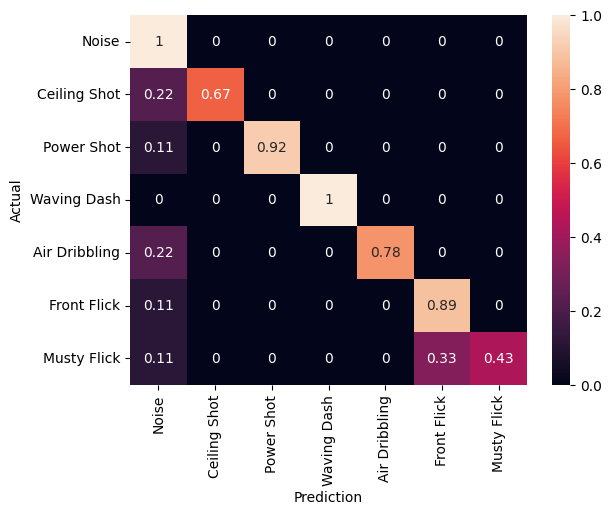

In [28]:
xgb_best_pred = xgb_cv_model.transform(test)
xgb_best_pred.select("prediction", 'class').show(5)
print_metrics(xgb_best_pred)

In [39]:
xgb_cv2 = SparkXGBClassifier(features_col='features',
                         label_col='class',
                         verbose=0,
                         random_state=seed)

xgb_param_grid2 = ParamGridBuilder()\
                .baseOn({xgb_cv2.n_estimators:200, xgb_cv2.learning_rate:0.1, xgb_cv2.max_depth: 8})\
                .addGrid(xgb_cv2.reg_lambda, [0, 0.1, 0.5 ])\
                .addGrid(xgb_cv2.reg_alpha, [0, 0.1, 0.3])\
                .addGrid(xgb_cv2.gamma, [0.01, 0.025, 0.05])\
                .addGrid(xgb_cv2.min_child_weight, [1, 1.1]).build()
"""
fissati: min_child_weight 1, gamma 0, subsample 1
"""
evaluator = MulticlassClassificationEvaluator(labelCol='class', predictionCol='prediction', metricName='accuracy')

xgb_cross_val2 = CrossValidator(estimator=xgb_cv2,
                              estimatorParamMaps=xgb_param_grid2,
                              evaluator=evaluator,
                              numFolds=4,
                              parallelism=2,
                              seed=seed)


In [ ]:
xgb_cv_model2 = xgb_cross_val2.fit(train)

In [53]:
print("Best parameters:")
print({k.name : v for (k,v) in xgb_cv_model2.getEstimatorParamMaps()[np.argmax(xgb_cv_model2.avgMetrics)].items()})

Best parameters:
{'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 8, 'reg_lambda': 0.1, 'reg_alpha': 0, 'gamma': 0.05, 'min_child_weight': 1, 'subsample': 1, 'colsample_bytree': 1}


In [9]:
xgb_cv_model2.save(path+"models/xgb/hyperParameterTuned2")

23/09/19 21:56:33 WARN TaskSetManager: Stage 80362 contains a task of very large size (1643 KiB). The maximum recommended task size is 1000 KiB.


2023-09-24 23:46:57,429 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


+----------+-----+
|prediction|class|
+----------+-----+
|       4.0|    4|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
+----------+-----+
only showing top 5 rows



2023-09-24 23:46:58,273 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2023-09-24 23:46:58,384 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


Accuracy: 
0.833
Weighted precision: 
0.899
Weighted recall: 
0.833


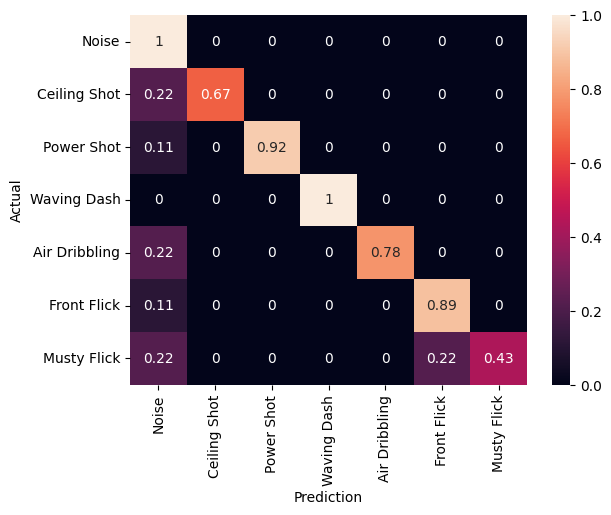

In [55]:
xgb_best_pred2 = xgb_cv_model2.transform(test)
xgb_best_pred2.select("prediction", 'class').show(5)
print_metrics(xgb_best_pred2)

## SVM

In [21]:
svm = OneVsRest(classifier=LinearSVC(), featuresCol='features', labelCol='class', parallelism=2)
svmf = svm.fit(train)
svmf.save(path+"models/svm/base")
svm_predictions = svmf.transform(test)

+-----+----------+
|class|prediction|
+-----+----------+
|    4|       4.0|
|    5|       5.0|
|    5|       5.0|
|    5|       0.0|
|    5|       5.0|
+-----+----------+
only showing top 5 rows

Accuracy: 
0.767
Weighted precision: 
0.815
Weighted recall: 
0.767


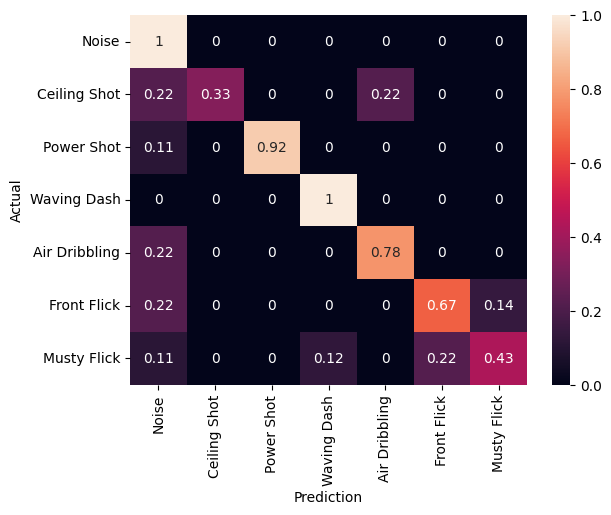

In [61]:
svm_predictions.select('class', 'prediction').show(5)
print_metrics(svm_predictions)

In [7]:
svm_base = LinearSVC()
svm_cv = OneVsRest(classifier=svm_base,featuresCol='features', labelCol='class')
svm_param_grid = ParamGridBuilder()\
    .addGrid(svm_base.maxIter, [50,100,500 ])\
    .addGrid(svm_base.regParam, [0.001, 0.01, 0.1, 1.0, 10, 100, 1000])\
    .addGrid(svm_base.fitIntercept, [True, False])\
    .addGrid(svm_base.tol, [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]).build()


evaluator = MulticlassClassificationEvaluator(labelCol='class', predictionCol='prediction', metricName='accuracy')
svm_cross_val = CrossValidator(estimator=svm_cv,
                              estimatorParamMaps=svm_param_grid,
                              evaluator=evaluator,
                              numFolds=4,
                              parallelism=2,
                              seed=seed)


In [ ]:
svm_cv_model = svm_cross_val.fit(train)

In [59]:
print("Best parameters:")
print({k.name : v for (k,v) in svm_cv_model.getEstimatorParamMaps()[np.argmax(svm_cv_model.avgMetrics)].items()})
svm_cv_model.save(path+"models/svm/hyperParameterTuned")

Best parameters:
{'fitIntercept': True, 'regParam': 0.1, 'tol': 0.01, 'maxIter': 50}


+----------+-----+
|prediction|class|
+----------+-----+
|       4.0|    4|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
+----------+-----+
only showing top 5 rows

Accuracy: 
0.817
Weighted precision: 
0.859
Weighted recall: 
0.817


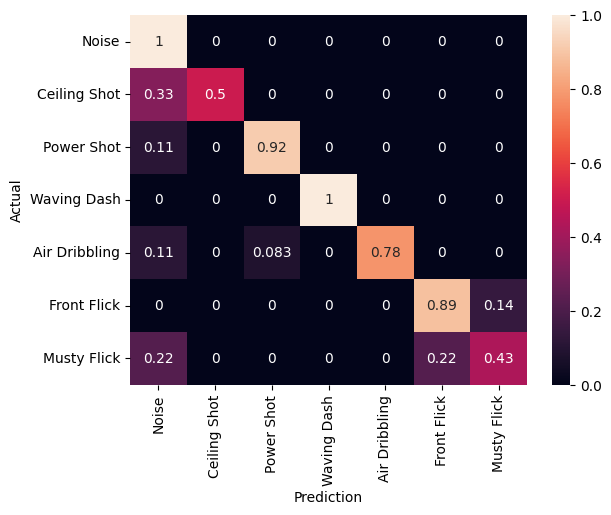

In [60]:
svm_best_pred = svm_cv_model.transform(test)
svm_best_pred.select("prediction", 'class').show(5)
print_metrics(svm_best_pred)

## Naive Bayes

In [12]:
nb = NaiveBayes(featuresCol='features', labelCol='class', smoothing=1e-9,
               modelType='gaussian')
nbf = nb.fit(train)
nbf.save(path+"models/nb/base")
nb_predictions = nbf.transform(test)

+-----+----------+
|class|prediction|
+-----+----------+
|    4|       4.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
+-----+----------+
only showing top 5 rows

Accuracy: 
0.667
Weighted precision: 
0.742
Weighted recall: 
0.667


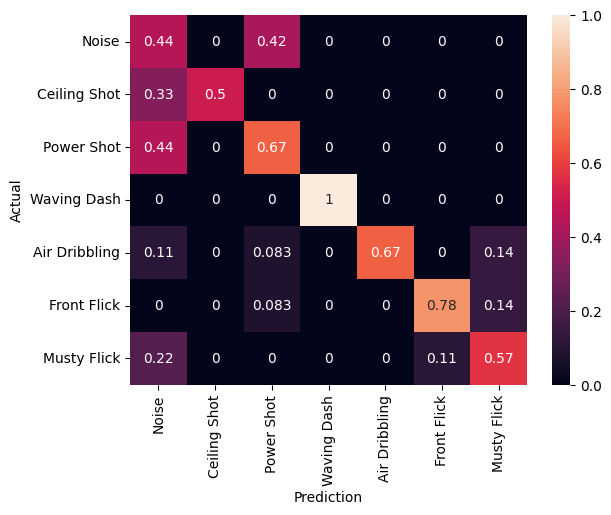

In [62]:
nb_predictions.select('class', 'prediction').show(5)
print_metrics(nb_predictions)

In [17]:
nb_cv = NaiveBayes(featuresCol='features', labelCol='class')

nb_param_grid = ParamGridBuilder()\
    .addGrid(nb_cv.smoothing, [1.0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-9])\
    .addGrid(nb_cv.modelType, ['multinomial','gaussian', 'bernoulli']).build()


evaluator = MulticlassClassificationEvaluator(labelCol='class', predictionCol='prediction', metricName='accuracy')
nb_cross_val = CrossValidator(estimator=nb_cv,
                              estimatorParamMaps=nb_param_grid,
                              evaluator=evaluator,
                              numFolds=4,
                              parallelism=2,
                              seed=seed)

In [ ]:
nb_cv_model = nb_cross_val.fit(train)

In [63]:
print("Best parameters:")
print({k.name : v for (k,v) in nb_cv_model.getEstimatorParamMaps()[np.argmax(nb_cv_model.avgMetrics)].items()})
nb_cv_model.save(path+"models/nb/hyperParameterTuned")

Best parameters:
{'modelType': 'bernoulli', 'smoothing': 0.01}


+----------+-----+
|prediction|class|
+----------+-----+
|       4.0|    4|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
+----------+-----+
only showing top 5 rows

Accuracy: 
0.783
Weighted precision: 
0.820
Weighted recall: 
0.783


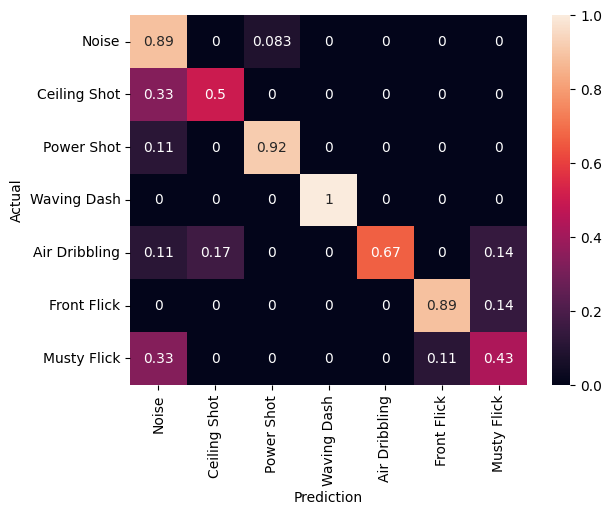

In [64]:
nb_best_pred = nb_cv_model.transform(test)
nb_best_pred.select("prediction", 'class').show(5)
print_metrics(nb_best_pred)

In [21]:
# generate predictions if the models have been loaded
dtc_predictions = dtcf.transform(test)
rfc_predictions = rfcf.transform(test)
xgb_predictions = xgbf.transform(test)
svm_predictions = svmf.transform(test)
nb_predictions = nbf.transform(test)

dtc_best_pred = dtc_cv_model.transform(test)
rfc_best_pred = rfc_cv_model.transform(test)
xgb_best_pred = xgb_cv_model.transform(test)
svm_best_pred = svm_cv_model.transform(test)
nb_best_pred = nb_cv_model.transform(test)

In [22]:
# generate metrics
dtc_metrics = compute_metrics(dtc_predictions)
rfc_metrics = compute_metrics(rfc_predictions)
xgb_metrics = compute_metrics(xgb_predictions)
svm_metrics = compute_metrics(svm_predictions)
nb_metrics = compute_metrics(nb_predictions)

dtc_best_metrics = compute_metrics(dtc_best_pred)
rfc_best_metrics = compute_metrics(rfc_best_pred)
xgb_best_metrics = compute_metrics(xgb_best_pred)
svm_best_metrics = compute_metrics(svm_best_pred)
nb_best_metrics = compute_metrics(nb_best_pred)


23/09/24 23:32:52 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
23/09/24 23:32:52 WARN DAGScheduler: Broadcasting large task binary with size 1384.6 KiB
23/09/24 23:32:52 WARN DAGScheduler: Broadcasting large task binary with size 1392.9 KiB


2023-09-24 23:32:54,189 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2023-09-24 23:32:54,301 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2023-09-24 23:32:58,484 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2023-09-24 23:32:59,036 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


23/09/24 23:33:00 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/09/24 23:33:00 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


In [29]:
model_names = ['DT', 'RF', 'XGB', 'SVM', 'NB']
final_metrics = [dtc_metrics, rfc_metrics, xgb_metrics, svm_metrics, nb_metrics]
improved_metrics = [dtc_best_metrics, rfc_best_metrics, xgb_best_metrics, svm_best_metrics, nb_best_metrics]
# width is used to control the width of the bars in the following plots
width=0.25

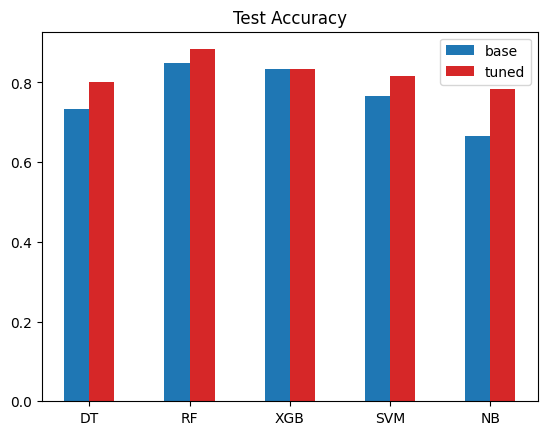

In [101]:
plt.title("Test Accuracy")
plt.bar(np.arange(len(model_names)),
        [i.accuracy for i in final_metrics],
        color='tab:blue', label='base',
       width=width)
plt.bar(np.arange(len(model_names))+width,
        [i.accuracy for i in improved_metrics],
        color='tab:red', label="tuned",
       width=width)
plt.xticks(np.arange(len(model_names))+width/2, model_names)
plt.legend()
plt.show()

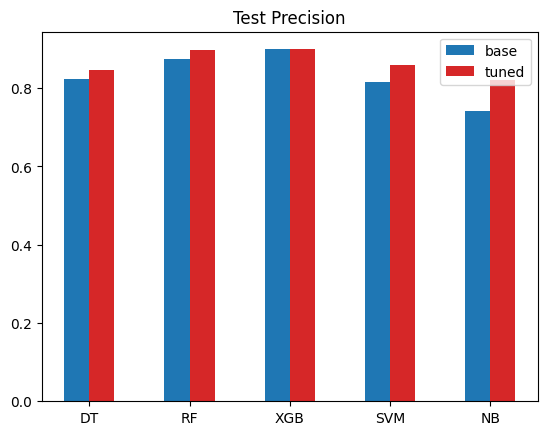

In [100]:
plt.title("Test Precision")
plt.bar(np.arange(len(model_names)),
        [i.weightedPrecision for i in final_metrics],
        color='tab:blue', label='base',
       width=width)
plt.bar(np.arange(len(model_names))+width,
        [i.weightedPrecision for i in improved_metrics],
        color='tab:red', label="tuned",
       width=width)
plt.xticks(np.arange(len(model_names))+width/2, model_names)
plt.legend()
plt.show()

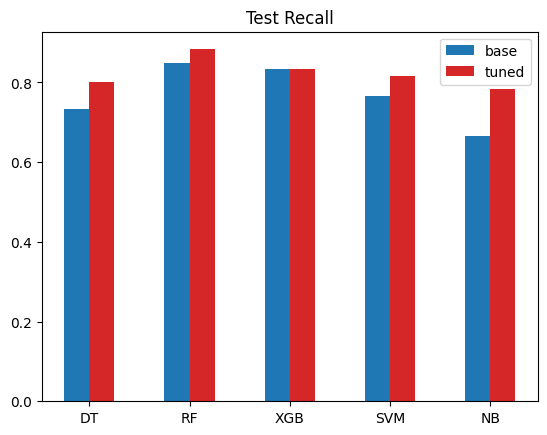

In [99]:
plt.title("Test Recall")
plt.bar(np.arange(len(model_names)),
        [i.weightedRecall for i in final_metrics],
        color='tab:blue', label="base",
       width=width)
plt.bar(np.arange(len(model_names))+width,
        [i.weightedRecall for i in improved_metrics],
        color='tab:red', label='tuned',
       width=width)
plt.xticks(np.arange(len(model_names))+width/2, model_names)
plt.legend()
plt.show()